# Year 4 AI CA2 Joshua Seymour N00181604

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
from datetime import datetime, date
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Reading in CSV and dropping un-needed columns

In [2]:
data = pd.read_csv('melb_data.csv')

newData = data.drop(['Address', 'Lattitude', 'Longtitude',  'CouncilArea'], axis = 'columns')
newData.head(5)
#CouncilArea is too similar to Suburb to keep.
#Address, Lattitude and Longtitude are too specific and un-needed.

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,Propertycount
0,Abbotsford,2,h,1480000,S,Biggin,03/12/2016,2.5,3067,2,1,1.0,202,NaN,NaN,Northern Metropolitan,4019
1,Abbotsford,2,h,1035000,S,Biggin,04/02/2016,2.5,3067,2,1,0.0,156,79.0,1900.0,Northern Metropolitan,4019
2,Abbotsford,3,h,1465000,SP,Biggin,04/03/2017,2.5,3067,3,2,0.0,134,150.0,1900.0,Northern Metropolitan,4019
3,Abbotsford,3,h,850000,PI,Biggin,04/03/2017,2.5,3067,3,2,1.0,94,NaN,NaN,Northern Metropolitan,4019
4,Abbotsford,4,h,1600000,VB,Nelson,04/06/2016,2.5,3067,3,1,2.0,120,142.0,2014.0,Northern Metropolitan,4019


In [3]:
newData['BuildingArea'].isna().sum()
#checking how many NaN / Null values for BuildingArea (6450)

6450

In [4]:
newData['Landsize'].isna().sum()
#checking how many NaN / Null values for Landsize (0)

0

In [5]:
newData['YearBuilt'].isna().sum()
#checking how many NaN / Null values for YearBuilt (5375)

5375

In [6]:
newData['Car'].isna().value_counts()
#checking how many NaN / Null values for Car (62)

False    13517
True        62
Name: Car, dtype: int64

# Car has only 62 NaN / Null values so I will be useing the median of car to fill in any missing values.

In [7]:
median_car = newData['Car'].median()
median_car

newData['Car'] = newData['Car'].fillna(median_car)

<AxesSubplot:>

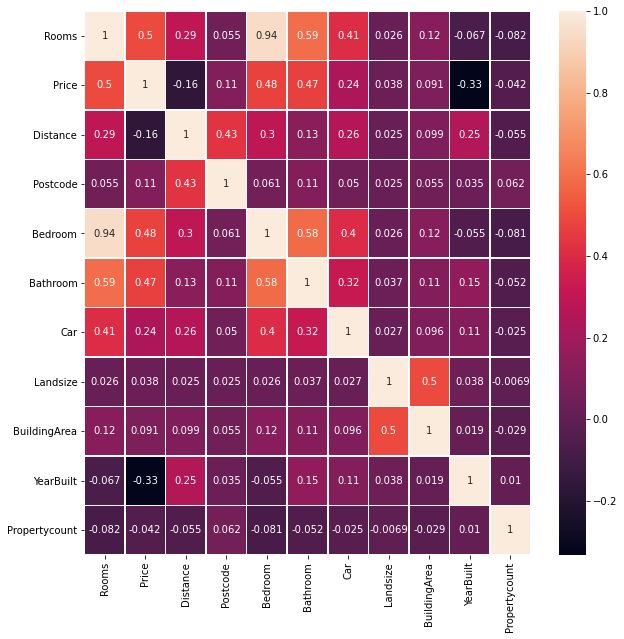

In [8]:
corr = newData.corr()
plt.figure(figsize=(10,10))
sb.heatmap(corr, annot=True, linewidth = 0.5)

# Cleaning YearBuilt Column of missing values and adding an Age column from YearBuilt

In [9]:
#Adding the median of Year built to missing values as there is a low negative correlation to price
median_year_built = newData['YearBuilt'].median()
median_year_built
#changing Null /NaN values to the median of YearBuilt
newData['YearBuilt'] = newData['YearBuilt'].fillna(median_year_built)

#Adding an age column from YearBuilt
def age(born):
    today = date.today()
    return today.year - born

newData['Age'] = newData['YearBuilt'].apply(age)

# I drop YearBuilt as there is now an Age Column

In [10]:
newData = newData.drop(['YearBuilt'], axis='columns')

In [11]:
newData['Age'].value_counts()

52.0     6241
62.0      725
72.0      580
122.0     341
42.0      338
         ... 
90.0        1
166.0       1
145.0       1
126.0       1
150.0       1
Name: Age, Length: 143, dtype: int64

<AxesSubplot:>

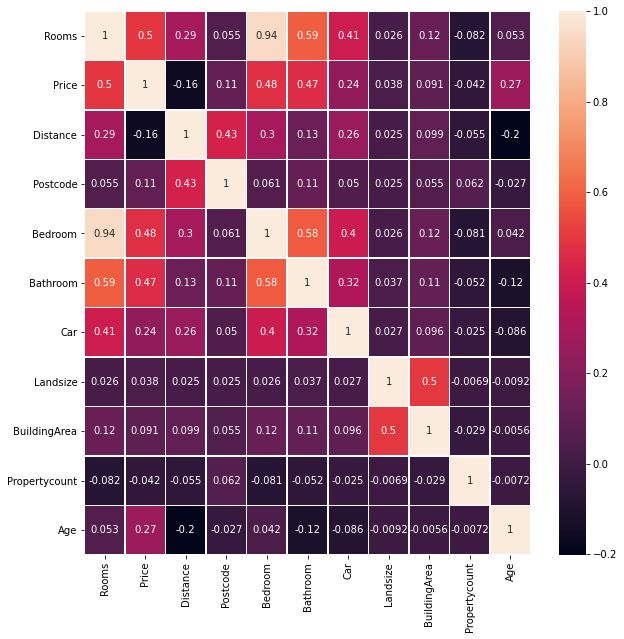

In [12]:
corr = newData.corr()
plt.figure(figsize=(10,10))
sb.heatmap(corr, annot=True, linewidth = 0.5)

In [13]:
newData['Regionname'].value_counts()

Southern Metropolitan         4695
Northern Metropolitan         3890
Western Metropolitan          2948
Eastern Metropolitan          1470
South-Eastern Metropolitan     450
Eastern Victoria                53
Northern Victoria               41
Western Victoria                32
Name: Regionname, dtype: int64

# From the above heatmap Landsize and BuildingArea have very low correlation to anything.
# Regionname is too general an area, Suburb will provide more useful information than Regionname.

In [14]:
newData = newData.drop(['Landsize', 'BuildingArea', 'Date', 'Regionname'], axis = 'columns')

# Finding how many unique values are in each of the following

In [15]:
newData['Type'].value_counts()

h    9448
u    3017
t    1114
Name: Type, dtype: int64

In [16]:
newData['Method'].value_counts()

S     9022
SP    1703
PI    1564
VB    1198
SA      92
Name: Method, dtype: int64

In [17]:
newData['SellerG'].value_counts()

Nelson              1565
Jellis              1316
hockingstuart       1167
Barry               1011
Ray                  701
                    ... 
Bowman                 1
Buxton/Advantage       1
Clairmont              1
White                  1
North                  1
Name: SellerG, Length: 268, dtype: int64

In [18]:
newData['Suburb'].value_counts()

Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Whittlesea          1
Bacchus Marsh       1
Sandhurst           1
Rockbank            1
Attwood             1
Name: Suburb, Length: 314, dtype: int64

In [19]:
newData['Postcode'].value_counts()

3073    359
3020    306
3121    292
3040    290
3046    284
       ... 
3438      1
3756      1
3782      1
3340      1
3158      1
Name: Postcode, Length: 198, dtype: int64

# Postcode is too similar to Suburb so i will drop it.

In [20]:
newData = newData.drop(['Postcode'], axis = 'columns')

In [21]:
inputs = newData.drop(['Rooms','Price','Distance','Bedroom','Bathroom','Car', 'Age','Propertycount'], axis = 1)

# Using Label Encoder to give a number to each unique name in the following columns.

In [22]:
le_suburb = LabelEncoder()
le_type = LabelEncoder()
le_method = LabelEncoder()
le_sellerg = LabelEncoder()

In [23]:
inputs['suburb_n'] = le_suburb.fit_transform(inputs['Suburb'])
inputs['type_n'] = le_type.fit_transform(inputs['Type'])
inputs['method_n'] = le_method.fit_transform(inputs['Method'])
inputs['sellerg_n'] = le_sellerg.fit_transform(inputs['SellerG'])
inputs

,Suburb,Type,Method,SellerG,suburb_n,type_n,method_n,sellerg_n
0,Abbotsford,h,S,Biggin,0,0,1,23
1,Abbotsford,h,S,Biggin,0,0,1,23
2,Abbotsford,h,SP,Biggin,0,0,3,23
3,Abbotsford,h,PI,Biggin,0,0,0,23
4,Abbotsford,h,VB,Nelson,0,0,4,155
...,...,...,...,...,...,...,...,...
13574,Wheelers Hill,h,S,Barry,302,0,1,16
13575,Williamstown,h,SP,Williams,305,0,3,251
13576,Williamstown,h,S,Raine,305,0,1,194
13577,Williamstown,h,PI,Sweeney,305,0,0,222


# Joining LabelEncoder numbers onto newData

In [24]:
inputs_n = inputs.drop(['Suburb','Type','Method','SellerG'], axis='columns')
newData = newData.join(inputs_n)

# Min max scaling the Propertycount data

In [25]:
propCount = newData[['Propertycount']]
scaler = MinMaxScaler()
rescaledPropCount = scaler.fit_transform(propCount)
rescaledPropCount

array([[0.17615999],
       [0.17615999],
       [0.17615999],
       ...,
       [0.28648194],
       [0.28648194],
       [0.29409841]])

Not scalingProperty count made the prediction more accurate.

In [26]:
#newData['ScaledPropertycount'] = rescaledPropCount

In [27]:
newData = newData.drop(['Suburb', 'Type', 'Method','SellerG'], axis = 'columns')

In [28]:
X = newData[['Rooms','Bedroom','Bathroom','Distance','Car', 'Age','Propertycount','suburb_n','type_n','method_n','sellerg_n']]
y = newData.Price  

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Using test train split with Linear Regression

In [30]:
clf = linear_model.LinearRegression()

In [31]:
clf.fit(X_train,y_train)

LinearRegression()

In [32]:
clf.score(X_test,y_test)

0.4362686937325553

# Using test train split with Decision Tree

In [33]:
model = tree.DecisionTreeClassifier()

In [34]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [35]:
model.score(X_test,y_test)

0.008100147275405008

# Using Test train split with Support Vector Machine (SVM)

In [36]:
model1 = SVC(C=10, gamma=100)
model1.fit(X_train,y_train)

SVC(C=10, gamma=100)

In [37]:
model1.score(X_test,y_test)

0.008100147275405008

# Using Test train split with Random Forest

In [38]:
model2 = RandomForestClassifier(n_estimators=60)
model2.fit(X_train,y_train)

RandomForestClassifier(n_estimators=60)

In [39]:
model2.score(X_test,y_test)

0.010309278350515464